# Comparison of Fitting Routines and Continuum Model Formulations

Check speed and handling of positivity constraint on decay rate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp

import DMdecay as dmd
import JWSTutils as jwst
from gnz11_split import partition_gnz11

# below is needed by the master fiting routine copied below
import copy

import scipy.optimize as opt
import scipy.interpolate as interp

from DMdecay import halo
from nestedtolist import nestedtolist

from DMdecay.linesearch import spline_residual, find_raw_limit

#### Importing data 
Use the data and configuration from arxiv v1

In [2]:
config_filename = "gnz11_split/gnz11_split.toml"

In [3]:
configs = dmd.prep.parse_configs(config_filename)
num_knots = configs["analysis"]["num_knots"]

data = jwst.process_datafiles(configs["run"]["paths"], 
                              configs["system"]["res_path"])
data = partition_gnz11(data, 
                       configs["run"]["lambda_min"],
                       configs["run"]["lambda_split"])
for spec in data:
    dmd.prep.doppler_correction(spec, configs["halo"])
    dmd.prep.add_Dfactor(spec, configs["halo"])
num_specs = len(data)
print(f"Loaded {num_specs} spectra")

parsing gnz11_split/gnz11_split.toml
processing 2 datafiles...
Loaded 2 spectra


#### Generalized fitting code

In the arxiv v1 analysis code, all the steps of a single line search at a given mass are implemented in one function find_raw_limit.  This is imported above for a cross-check.  Here I implement some of the pre-processing done by this function, but generalize it to be able to swap in different continuum models and different optimizers. 

In [83]:

def faster_polyval(p, x):
    """ 
    evaluate a polynomial of coefficients p at x, where p lists the coefficents
    from larger-power to least
    """
    y = np.zeros(x.shape, dtype=float)
    for i, v in enumerate(p):
        y *= x
        y += v
    return y


def vector_polyval(p, x):
    """ 
    A fully vectorized polynomial evaluation, which has a worse scaling with
    the degree of the polynomial than faster_polyval but pushes all loops to c
    """
    n = np.arange(p.size)
    return np.sum(p*(x[..., None]**n), axis=-1)


def polynomial_residual(knot_values, x, y, sigma_y):
    """ 
    Calculate the residuals for a polynomial fit.  This is to be compared with
    a spline fit of a fixed number of knots, so here we take that number of
    knots as the number of polynomial terms so the number of fit params is the
    same.
    """
    num_specs = len(x)
    num_knots = int(knot_values.size/num_specs)
    resiudal_list = []
    for i in range(num_specs):
        start = i*num_knots
        end = (i + 1)*num_knots
        poly = faster_polyval(knot_values[start:end], x[i])
        resiudal_list.append((y[i] - poly)/sigma_y[i])
    return np.concatenate(resiudal_list)

def polynomial_residual_jacobian(knot_values, x, y, sigma_y):
    """ 
    Evaluate the jacobian of the polynomial_residual.  This returns an (m, n)
    array where m is the total number of data points in all of the lists x and
    n is the number of fit parameters.  This needs to have the same call
    signature as polynomial_residual per the scipy.optimize.least_squares
    documentation.
    """
    num_specs = len(x)
    num_knots = int(knot_values.size/num_specs)
    jacobian_list = []
    for i in range(num_specs):
        jacobian = np.zeros((x[i].size, knot_values.size))
        start = i*num_knots
        end = (i + 1)*num_knots
        n = np.arange(num_knots)[::-1]
        jacobian[:, start:end] = -(x[i][:, None]**n)/sigma_y[i][:, None]
        jacobian_list.append(jacobian)
    return np.vstack(jacobian_list)

In [90]:
def compare_fits(configs, data, lam0, 
                 model="spline", method=None, jac=None):
    padding = configs["analysis"]["padding"]
    num_knots = configs["analysis"]["num_knots"]
    max_clip_iters = configs["analysis"]["max_clip_iters"]
    clipping_factor = configs["analysis"]["clipping_factor"]
    chisq_step = configs["analysis"]["chisq_step"]
    limit_guess = configs["analysis"]["limit_guess"] 
    window = configs["analysis"]["width_factor"]*configs["halo"]["sigma_v"]
    # extract line search region 
    sky_list = []
    lam_list = []
    raw_error_list = []
    fixed_list = []
    spec_list = []
    res_list = []
    lstart = [spec["lam"][0] for spec in data]
    lend = [spec["lam"][-1] for spec in data]
    lmin = lam0*(1.0 - 0.5*window)
    lmax = lam0*(1.0 + 0.5*window)
    for i, spec in enumerate(data):
        if (lam0 < lstart[i]) or (lam0 > lend[i]):
            continue
        if lmin < lstart[i]:
            l_left = lstart[i]
            l_right = l_left*(1 + window)
        elif lend[i] < lmax:
            l_right = lend[i]
            l_left = l_right*(1 - window)
        else:
            l_left = lmin
            l_right = lmax
        select = (l_left < spec["lam"]) & (spec["lam"] < l_right)
        spec_list.append(i)
        sky_list.append(spec["sky"][select])
        lam_list.append(spec["lam"][select])
        raw_error_list.append(spec["error"][select])
        fixed_list.append([lam0, spec["D"], 
                           halo.sigma_from_fwhm(spec["res"], lam0, 
                                                configs["halo"]["sigma_v"])])    
        res_list.append(spec["res"])
    num_specs = len(sky_list)
    if num_specs == 0:
        return [[lmin, lmax], spec_list, [None], [None], 
                [np.nan, None], [np.nan, None], np.nan, None, 
                None, lam0, None, None, None, None, None, None]

    # fit continuum
    if model == "spline":
        knots = np.zeros(num_specs*num_knots)
        initial_knot_values = np.zeros(num_specs*num_knots)
        for i in range(num_specs):
            start = i*num_knots
            end = (i + 1)*num_knots
            knots[start:end] = np.linspace(lam_list[i][0]*(1 + padding), 
                                        lam_list[i][-1]*(1 - padding), 
                                        num_knots)
            initial_knot_values[start:end] = (
                interp.interp1d(lam_list[i], sky_list[i])(knots[start:end]))
        continuum_fit = opt.least_squares(
            spline_residual, initial_knot_values,
            args=(knots, lam_list, sky_list, raw_error_list),
            method=method)
    if model == "polynomial":
        knots = None
        initial_knot_values = np.zeros(num_specs*num_knots)
        for i in range(num_specs):
            end = (i + 1)*num_knots - 1
            # initial guess is a line through the medians of 
            # the left and right halves of the data
            lam_med = np.median(lam_list[i])
            x1 = np.median(lam_list[i][lam_list[i] < lam_med])
            x2 = np.median(lam_list[i][lam_list[i] > lam_med])
            y1 = np.median(sky_list[i][lam_list[i] < lam_med])
            y2 = np.median(sky_list[i][lam_list[i] > lam_med])
            slope = (y2 - y1)/(x2 - x1)
            intercept = y1 - slope*x1
            initial_knot_values[end-1] = slope
            initial_knot_values[end] = intercept
        if jac is None:
            jac = polynomial_residual_jacobian(initial_knot_values, 
                                            lam_list, sky_list, raw_error_list)
            jac_func = lambda x, l, s, re: jac
        else:
            jac_func = jac
        continuum_fit = opt.least_squares(
            polynomial_residual, initial_knot_values,
            args=(lam_list, sky_list, raw_error_list),
            method=method, jac=jac_func)
    best_knot_values = continuum_fit["x"]
    error_scale_factors = None
    limit_rate = None
    limit_knots = None
    best_rate = None
    delta_chisq = None
    lam_list_msk = None
    error_list_msk = None
    error_list= raw_error_list    
    return [[lmin, lmax], spec_list, knots, error_scale_factors, 
                [limit_rate, limit_knots], [best_rate, best_knot_values],
                delta_chisq, lam_list_msk, error_list_msk, lam0,
                sky_list, lam_list, error_list, fixed_list, 
                spec_list, res_list, initial_knot_values]

test this 

In [106]:
lam0 = 2.44 # um, used in previous examples 
out_spline = compare_fits(configs, data, lam0, model="spline", method="trf")
out_poly = compare_fits(configs, data, lam0, model="polynomial", method="trf", jac="2-point")

[[lmin, lmax], 
     spec_list, 
     knots, 
     error_scale_factors,
     [limit_rate, limit_knots], 
     [best_rate, best_knots_spline],
     delta_chisq,
     lam_list_msk, 
     error_list_msk, 
     lam0_tmp,
     sky_list, 
     lam_list, 
     error_list, 
     fixed_list, 
     spec_list, 
     res_list, initial_knot_spline] = out_spline
best_coefs_poly = out_poly[5][1]
initial_coefs_poly = out_poly[16]

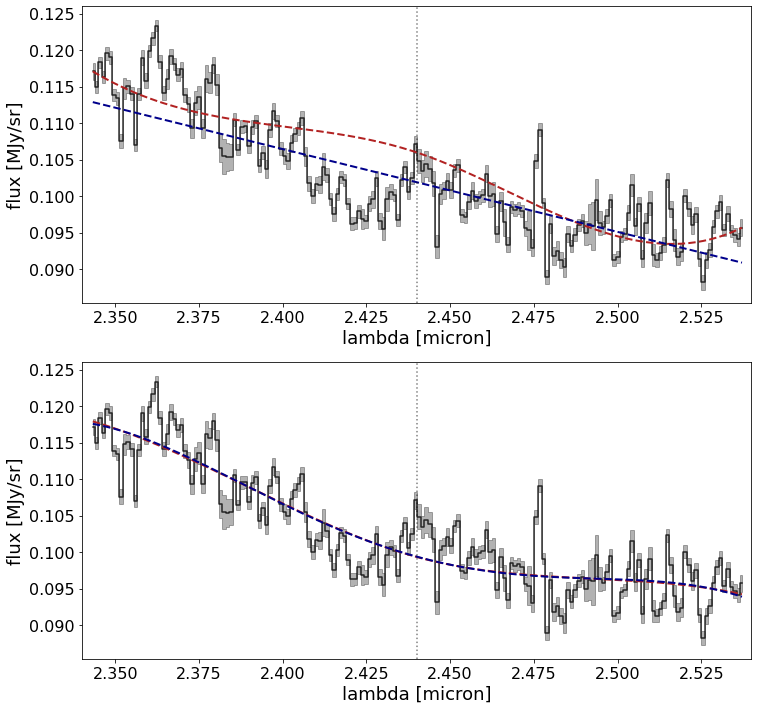

In [107]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
num_fitted_specs = len(knots)//num_knots
loop = zip(axes, 
           [initial_knot_spline, best_knots_spline], 
           [initial_coefs_poly, best_coefs_poly])
for ax, spline, poly in loop:
        for i in range(num_fitted_specs):
                start = i*num_knots
                end = (i + 1)*num_knots
                ax.fill_between(lam_list[i], 
                                sky_list[i] - error_list[i], 
                                sky_list[i] + error_list[i], step="mid",
                                color='black', alpha=0.3)
                ax.step(lam_list[i], sky_list[i], where="mid",
                        color='black', alpha=0.8)
                # limiting model 
                continuum_model = interp.CubicSpline(knots[start:end], 
                                                spline[start:end])
                poly_model = faster_polyval(poly[start:end], lam_list[i])
                ax.plot(lam_list[i], continuum_model(lam_list[i]), 
                        color='firebrick', linestyle='dashed', marker='', 
                        linewidth=2, alpha=1)
                ax.plot(lam_list[i], poly_model, 
                        color='darkblue', linestyle='dashed', marker='', 
                        linewidth=2, alpha=1)
                ax.axvline(lam0, linestyle='dotted', color='black', alpha=0.5)

                ax.set_xlim(lam0 - 0.1, lam0 + 0.1)
                ax.set_xlabel(r"lambda [micron]", fontsize=18)
                ax.set_ylabel(r"flux [MJy/sr]", fontsize=18)
                ax.tick_params(axis='both', which='major', labelsize=16)

First compare evaluation of the models

In [99]:
%timeit continuum_model(lam_list[0])

9 µs ± 648 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [96]:
%timeit faster_polyval(best_coefs_poly[start:end], lam_list[0])

11.9 µs ± 710 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [98]:
%timeit vector_polyval(best_coefs_poly[start:end], lam_list[0])

30.3 µs ± 985 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


So it seems the spline is fastest.  It must just be a faster computation under the
hood of numpy.  I would have guessed it would be the other way around. 

Between the two polynomials, I am also surprised that the explicit python loop
one wins. 


Now compare optimizer routines 

For spline I have no analytic Jacobian (should be able to work it out though)

In [88]:
%timeit compare_fits(configs, data, lam0, model="spline", method='trf')

%timeit compare_fits(configs, data, lam0, model="spline", method='lm')

3.23 ms ± 57 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.02 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Compare to polynomial with numerical Jacobian

In [92]:
%timeit compare_fits(configs, data, lam0, model="polynomial", method='trf', jac="2-point")

%timeit compare_fits(configs, data, lam0, model="polynomial", method='lm', jac="2-point")

8.76 ms ± 91.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.75 ms ± 67.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Surprising.  The polynomial model is slightly slower to evaluate, by about 10%, which
would lead to me to guess that fits to the polynomial model would be slower in
general.  This is true for trf but not for lm.  I don't understand these two
algorithms well enough to understand why this is the case.  It must be that lm
somehow requires more evaluations of the model than trf when running with the
spline, but then on the polynomial it requires less. 

and now polynomial with analytic Jacobian

In [91]:
%timeit compare_fits(configs, data, lam0, model="polynomial", method='trf')

%timeit compare_fits(configs, data, lam0, model="polynomial", method='lm')

3.6 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
510 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This is as expected - the Jacobian speeds it up for both routines.
